# ICESpark Ice Sat 2 Orbit Crossing with Sentinel-2 and WorldView-3 images


In [35]:
import os

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import *

from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.utils.adapter import Adapter

In [36]:
spark = SparkSession. \
    builder. \
    appName('appName'). \
    master('local[*]'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.2.0-incubating,org.datasyslab:geotools-wrapper:1.1.0-25.2'). \
    getOrCreate()

In [37]:
SedonaRegistrator.registerAll(spark)
sc = spark.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")

## Load ICE_SAT2 orbits (size 2.6GB, 13704 orbits) into Spark
Files are originally in KML. They are converted to a single WKT file using GDAL ogr2ogr command.

Filename example: IS2_RGT_0702_cycle3_14-May-2019.kml.csv

In [38]:
ice2_df = spark.read.format("csv").\
    option("delimiter", ",").\
    option("header", "true").\
    load("data/IS2_RGTs_aggr_data_timestamp-head500csv").repartition(10)

ice2_df.createOrReplaceTempView("is2_df_raw")

ice2_df.show(2)

print(ice2_df.count())


+--------------------+-------+-----------+---------+-----+----+-------------+----------+-------+----------+---------+----+--------------------+
|                 WKT|   Name|description|timestamp|begin| end| altitudeMode|tessellate|extrude|visibility|drawOrder|icon|            filename|
+--------------------+-------+-----------+---------+-----+----+-------------+----------+-------+----------+---------+----+--------------------+
|LINESTRING (-36.7...| RGT 94|       null|     null| null|null|clampToGround|        -1|      0|         1|     null|null|IS2_RGT_0094_cycl...|
|LINESTRING (104.2...|RGT 149|       null|     null| null|null|clampToGround|        -1|      0|         1|     null|null|IS2_RGT_0149_cycl...|
+--------------------+-------+-----------+---------+-----+----+-------------+----------+-------+----------+---------+----+--------------------+
only showing top 2 rows

13704


## Create Apache Sedona DataFrame

In [39]:
ice2_df = spark.sql("select ST_FlipCoordinates(ST_GeomFromWKT(WKT)) as orbit, Name, altitudeMode, tessellate, extrude, visibility, filename from is2_df_raw").cache()
ice2_df.createOrReplaceTempView("is2_df")
ice2_df.show(2)
ice2_df.select("filename").show(2, truncate = False)
print(ice2_df.count())

+--------------------+------+-------------+----------+-------+----------+--------------------+
|               orbit|  Name| altitudeMode|tessellate|extrude|visibility|            filename|
+--------------------+------+-------------+----------+-------+----------+--------------------+
|LINESTRING (0.026...|RGT 17|clampToGround|        -1|      0|         1|IS2_RGT_0017_cycl...|
|LINESTRING (0.037...|RGT 35|clampToGround|        -1|      0|         1|IS2_RGT_0035_cycl...|
+--------------------+------+-------------+----------+-------+----------+--------------------+
only showing top 2 rows

+---------------------------------------+
|filename                               |
+---------------------------------------+
|IS2_RGT_0097_cycle7_01-Apr-2020.kml.csv|
|IS2_RGT_0130_cycle3_06-Apr-2019.kml.csv|
+---------------------------------------+
only showing top 2 rows

13704


## Operations

**Two Sentinel-2 image bounding boxes (lat, lon format)**

S-2 image from June 22, 2019:
```
UL: 82.852919, -63.001439
LL: 81.869306, -63.001267
UR: 82.785942, -55.145842
LR: 81.810456, -56.080844
```

Polygon format (UL - LL - LR - UR - UL): 82.852919, -63.001439, 81.869306, -63.001267, 81.810456, -56.080844, 82.785942, -55.145842, 82.852919, -63.001439

S-2 image from September 3, 2019:
```
UL: 79.232286, -121.801758
LL: 78.251639, -121.405181
UR: 79.268856, -116.530467
LR: 78.285072, -116.569403
```

Polygon format (UL - LL - LR - UR - UL): 79.232286, -121.801758, 78.251639, -121.405181, 78.285072, -116.569403, 79.268856, -116.530467, 79.232286, -121.801758

**WorldView image bounding boxes (lat, lon format)**

WV-3 image from April 10, 2019
```
UL: 79.76066207, -114.09955772
LL: 79.62275657, -114.06853064
UR: 79.83858880, -112.31487793
LR: 79.69303180, -112.34933739
```

Polygon format (UL - LL - LR - UR - UL): 79.76066207, -114.09955772, 79.62275657, -114.06853064, 79.69303180, -112.34933739, 79.83858880, -112.31487793, 79.76066207, -114.09955772

WV-2 image from April 10, 2019
```
UL: 80.0576610499, -110.56248745
LL: 79.9244458799, -110.56242819
UR: 80.044587680, -109.42456569
LR: 79.9092631399, -109.42423191
```

Polygon format (UL - LL - LR - UR - UL): 80.0576610499, -110.56248745, 79.9244458799, -110.56242819, 79.9092631399, -109.42423191, 80.044587680, -109.42456569, 80.0576610499, -110.56248745

WV-2 image from June 25, 2020
```
UL: 84.04474275, -60.80835633
LL: 83.90936693, -60.7855143
UR: 84.04404486, -59.21133579
LR: 83.90966186, -59.23332056
```

Polygon format (UL - LL - LR - UR - UL): 84.04474275, -60.80835633, 83.90936693, -60.7855143, 83.90966186, -59.23332056, 84.04404486, -59.21133579, 84.04474275, -60.80835633

### Check if orbits intersect S-2 and/or WorldView bounding boxes

In [40]:
# modified projection

#result_df1 = spark.sql('SELECT * '
#                      'FROM is2_df '
#                      'WHERE ST_Intersects(orbit, ST_PolygonFromText (\'82.852919, -63.001439,81.869306, -63.001267, 81.810456, -56.080844, 82.785942, -55.145842, 82.852919, -63.001439\',\',\'))')
#result_df1.show(2)
#print('Sentinel-2 A number of crosses: ', result_df1.count())

#result_df2 = spark.sql('SELECT * '
#                      'FROM is2_df '
#                      'WHERE ST_Intersects(orbit, ST_PolygonFromText (\'79.232286, -121.801758, 78.251639, -121.405181, 78.285072, -116.569403, 79.268856, -116.530467, 79.232286, -121.801758\',\',\'))')
#print('Sentinel-2 B number of crosses: ', result_df2.count())

result_df3 = spark.sql('SELECT * '
                      'FROM is2_df '
                      'WHERE ST_Intersects(orbit, ST_PolygonFromText (\'79.76066207, -114.09955772, 79.62275657, -114.06853064, 79.69303180, -112.34933739, 79.83858880, -112.31487793, 79.76066207, -114.09955772\',\',\'))')
print('WorldView A number of crosses: ', result_df3.count())

#result_df4 = spark.sql('SELECT * '
#                      'FROM is2_df '
#                      'WHERE ST_Intersects(orbit, ST_PolygonFromText (\'80.0576610499, -110.56248745, 79.9244458799, -110.56242819, 79.9092631399, -109.42423191, 80.044587680, -109.42456569, 80.0576610499, -110.56248745\',\',\'))')
#print('WorldView B number of crosses: ', result_df4.count())

#result_df5 = spark.sql('SELECT * '
#                      'FROM is2_df '
#                      'WHERE ST_Intersects(orbit, ST_PolygonFromText (\'84.04474275, -60.80835633, 83.90936693, -60.7855143, 83.90966186, -59.23332056, 84.04404486, -59.21133579, 84.04474275, -60.80835633\',\',\'))')
#print('WorldView C number of crosses: ', result_df5.count())

WorldView A number of crosses:  158


**Find orbits in Year 2019 in the S-2 A result**

In [41]:
#result_df1.createOrReplaceTempView("s2_a")
#result_df1 = spark.sql('SELECT * '
#                       'FROM s2_a '
#                       'WHERE filename LIKE \'%22-Jun-2019%\'')
#result_df1.select('filename').show(result_df1.count(), truncate = False)

### Find orbits in Year 2019 in the S-2 B result

In [42]:
#result_df2.createOrReplaceTempView("s2_b")
#result_df2 = spark.sql('SELECT * '
#                       'FROM s2_b '
#                       'WHERE filename LIKE \'%2019%\'')
#result_df2.select('filename').show(result_df2.count(), truncate = False)

### Find orbits in Year 2019 in the WorldView A result

In [43]:
result_df3.createOrReplaceTempView("wv_a")
result_df3 = spark.sql('SELECT * '
                       'FROM wv_a '
                       'WHERE filename LIKE \'%10-Apr-2019%\'')
result_df3.select('filename').show(result_df3.count(), truncate = False)

+---------------------------------------+
|filename                               |
+---------------------------------------+
|IS2_RGT_0188_cycle3_10-Apr-2019.kml.csv|
+---------------------------------------+



### Find orbits in April 2019 in the WorldView B result

In [11]:
#result_df4.createOrReplaceTempView("wv_b")
#result_df4 = spark.sql('SELECT * '
#                       'FROM wv_b '
#                       'WHERE filename LIKE \'%Apr-2019%\'')
#result_df4.select('filename').show(result_df4.count(), truncate = False)

+---------------------------------------+
|filename                               |
+---------------------------------------+
|IS2_RGT_0325_cycle3_19-Apr-2019.kml.csv|
|IS2_RGT_0367_cycle3_22-Apr-2019.kml.csv|
|IS2_RGT_0425_cycle3_26-Apr-2019.kml.csv|
|IS2_RGT_0386_cycle3_23-Apr-2019.kml.csv|
+---------------------------------------+



## Visualize the query result using GeoPandas

### Read a country shapefile as the base map using Sedona

In [44]:
countries = ShapefileReader.readToGeometryRDD(sc, "data/ne_50m_admin_0_countries_lakes")
countries_df = Adapter.toDf(countries, spark).select("geometry", "NAME_EN")
countries_df.show(2)

+--------------------+--------+
|            geometry| NAME_EN|
+--------------------+--------+
|POLYGON ((31.2878...|Zimbabwe|
|POLYGON ((30.3960...|  Zambia|
+--------------------+--------+
only showing top 2 rows



**Put S-2 A into a Sedona DF**

In [13]:
#s2_a = spark.sql('SELECT ST_FlipCoordinates(ST_PolygonFromText (\'82.852919, -63.001439, 81.869306, -63.001267, 81.810456, -56.080844, 82.785942, -55.145842, 82.852919, -63.001439\',\',\')) as s2a')
#s2_a.show()

### Put S-2 A, B, and WorldView into a Sedona DF

In [45]:
#s2_a = spark.sql('SELECT ST_FlipCoordinates(ST_PolygonFromText (\'82.852919, -63.001439, 81.869306, -63.001267, 81.810456, -56.080844, 82.785942, -55.145842, 82.852919, -63.001439\',\',\')) as s2a')
#s2_b = spark.sql('SELECT ST_FlipCoordinates(ST_PolygonFromText (\'79.232286, -121.801758, 78.251639, -121.405181, 78.285072, -116.569403, 79.268856, -116.530467, 79.232286, -121.801758\',\',\')) as s2b')
wv_a = spark.sql('SELECT ST_FlipCoordinates(ST_PolygonFromText (\'79.76066207, -114.09955772, 79.62275657, -114.06853064, 79.69303180, -112.34933739, 79.83858880, -112.31487793, 79.76066207, -114.09955772\',\',\')) as wva')
#s2_a.show()
#s2_b.show()
#wv_a.show()

### Convert Sedona DataFrame to GeoPandas DataFrame

In [46]:
country_gpd = gpd.GeoDataFrame(countries_df.toPandas(), geometry="geometry")
## Separate lines for each example
#s2_gpd = gpd.GeoDataFrame(s2_a.toPandas(), geometry="s2a")
#s2_gpd = gpd.GeoDataFrame(s2_b.toPandas(), geometry="s2b")
wv_gpd = gpd.GeoDataFrame(wv_a.toPandas(), geometry="wva")
#orbit_gpd = gpd.GeoDataFrame(result_df1.selectExpr('ST_FlipCoordinates(orbit) as orbit').toPandas(), geometry="orbit")
#orbit_gpd = gpd.GeoDataFrame(result_df2.selectExpr('ST_FlipCoordinates(orbit) as orbit').toPandas(), geometry="orbit")
orbit_gpd = gpd.GeoDataFrame(result_df3.selectExpr('ST_FlipCoordinates(orbit) as orbit').toPandas(), geometry="orbit")

### Plot the maps

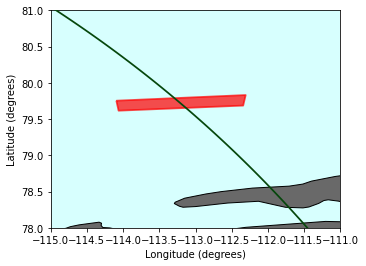

In [51]:
base = country_gpd.plot(color='dimgray', edgecolor='black', zorder=1)
base.set_facecolor('#d7fffe')
# Sentinel-2 A view
#base.set_xlim(-65, -54)
#base.set_ylim(80, 85.5)
# Sentinel-2 B view
#base.set_xlim(-125, -113)
#base.set_ylim(72, 80)
# WorldView A view
base.set_xlim(-115, -111)
base.set_ylim(78, 81)
# Global view
#base.set_xlim(-180, 180)
#base.set_ylim(-90, 90)
base.set_xlabel('Longitude (degrees)')
base.set_ylabel('Latitude (degrees)')
orbit = orbit_gpd.plot(ax=base, color='#06470c', linewidth=1.75, label='IS2 RGT 1298 & 1307', zorder=3)
#s2 = s2_gpd.plot(ax=orbit, color='red', alpha=0.7, edgecolor='red', linewidth=1.75, zorder=2)
wv = wv_gpd.plot(ax=orbit, color='red', alpha=0.7, edgecolor='red', linewidth=1.75, label='WV-2 Image', zorder=2)
#plt.legend(loc='upper right', framealpha=1)
#plt.title('June 22, 2019 Sentinel-2 and IS-2 crossing')
#plt.show()